In [50]:
from importlib import reload

import numpy as np

import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr


## library to read lung cancer database
from sqlalchemy import func # required to query the db
import thirdparty.pylidc.pylidc as pl

pl = reload(pl)

In [51]:
print(pl)

<module 'thirdparty.pylidc.pylidc' from '/gpfs_new/data/users/jbetancur/home/dev/rxtools/thirdparty/pylidc/pylidc/__init__.py'>


### Read Lung Cancer Database files
Follow instructions at:

https://pylidc.github.io/

When running the code below, if getting errors such as np.bool not found or np.int not found, change the sources as follows

- replace *np.int* by *int*

- replace *np.bool* by *bool*

In [62]:
### to generate the complete dataset, the code below has to be looped over all patients IDs
pid = 'LIDC-IDRI-0001' # patient ID 
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first() # scan class instance for patient ID

In [140]:
vol = scan.to_volume() # creating numpy array with scan volume
print(scan)
print(scan.pixel_spacing)
vol_shape=vol.shape


print(vol_shape)
print(type(vol))


Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)
0.703125
(512, 512, 133)
<class 'numpy.ndarray'>


### Visualize mid slice of CT volume

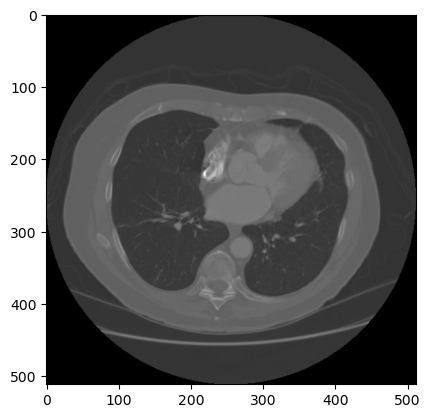

In [9]:
plt.imshow(vol[:, :, round(vol_shape[2]/2)].squeeze(), cmap='gray')

### Compute x-ray projections and create Annotations Gold Standard

Compute x-ray projections from CT volumes. Also, create a volume with the annotations.

In [190]:
### parameters of the geometry of projection
# We use diff DRR made to have differentiable DRR from CT volumes. Diff DRR is customized for cone-beam CTs
# https://github.com/eigenvivek/DiffDRR

sdr = 750  ## source-to-detector radius 
height = 256 ### size of the projected image
delx = (4*200)/height
spacing = np.array([scan.pixel_spacing,scan.pixel_spacing, scan.slice_spacing])
print(spacing)

# Initialize the DRR module for generating synthetic X-rays
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### poses of camera to create projections ### this provides the geometric constraint
### Diff DRR being created for a cone beam CT, lets try these
# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
#rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
rot_x=0.0
rot_y=0.0
rot_z=3*torch.pi/2
rotation = torch.tensor([[rot_x, rot_y, rot_z]], device=device)
#rotation = torch.tensor([[0.0, 2*torch.pi/10 , torch.pi / 2]], device=device)

bx, by, bz = torch.tensor(vol.shape) * torch.tensor(spacing) / 2 ### center of the CT volume in mm
translation = torch.tensor([[bx, by, bz]], device=device) ### to check how this defines the camera pose in diffDRR
print(translation )


[0.703125 0.703125 2.5     ]
cpu
tensor([[180.0000, 180.0000, 166.2500]], dtype=torch.float64)


0.0


<Figure size 640x480 with 0 Axes>

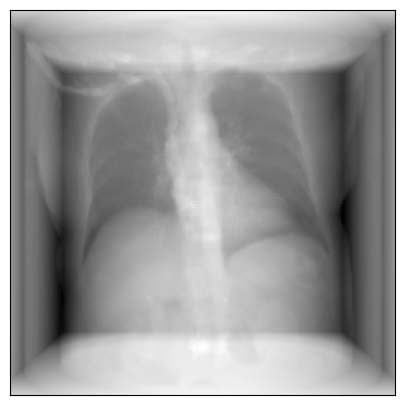

1.2566370614359172


<Figure size 640x480 with 0 Axes>

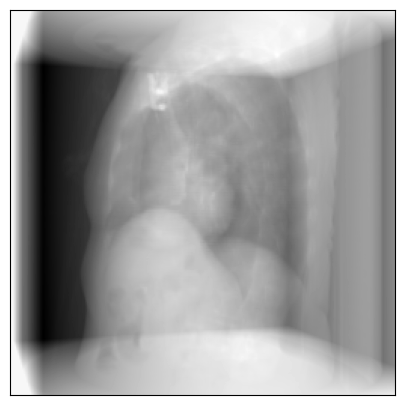

2.5132741228718345


<Figure size 640x480 with 0 Axes>

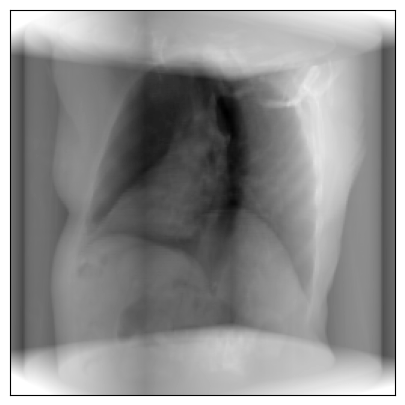

3.7699111843077517


<Figure size 640x480 with 0 Axes>

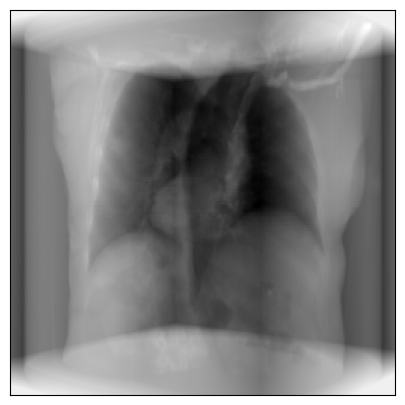

5.026548245743669


<Figure size 640x480 with 0 Axes>

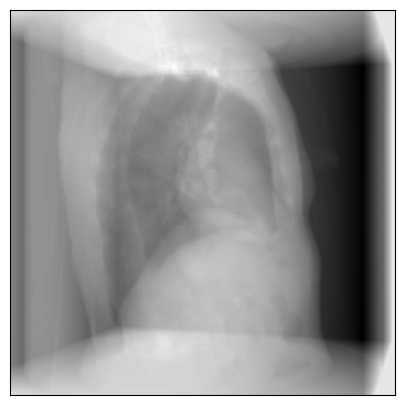

In [193]:
## create drr object from CT
drr = DRR(
    vol,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=sdr,   # Source-to-detector radius (half of the source-to-detector distance)
    height=height,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=delx,    # Pixel spacing (in mm)
).to(device)

### create drr images using drr object for N_views. Each view is a rotation around the x axis of 360°/N_views from 0°
N_views = 5
for idx_x in range(N_views):
    rad_x = idx_x*2*torch.pi/N_views
    print(rad_x)
    rotation = torch.tensor([[rad_x, rot_y , rot_z]], device=device) 

    # 📸 Also note that DiffDRR can take many representations of SO(3) 📸
    # For example, quaternions, rotation matrix, axis-angle, etc...
    img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
    ### here use your favorite tool to save the created xray images.
    ##visualisation
    plt.figure()
    plot_drr(img, ticks=False)
    plt.show()

0.0


<Figure size 640x480 with 0 Axes>

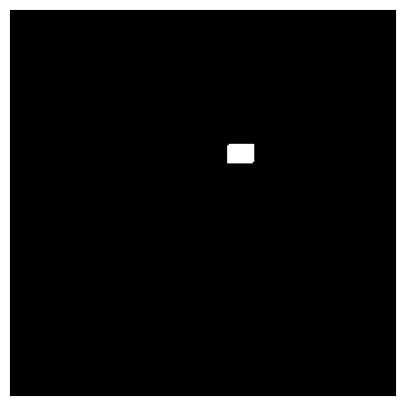

1.2566370614359172


<Figure size 640x480 with 0 Axes>

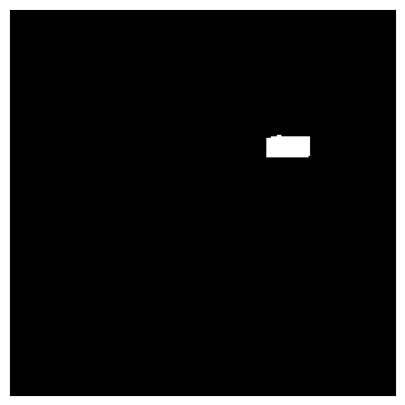

2.5132741228718345


<Figure size 640x480 with 0 Axes>

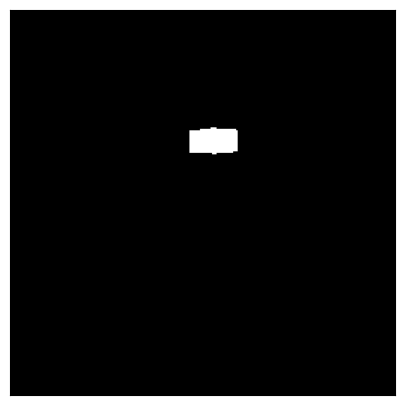

3.7699111843077517


<Figure size 640x480 with 0 Axes>

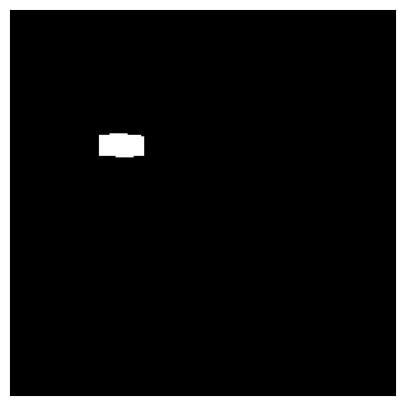

5.026548245743669


<Figure size 640x480 with 0 Axes>

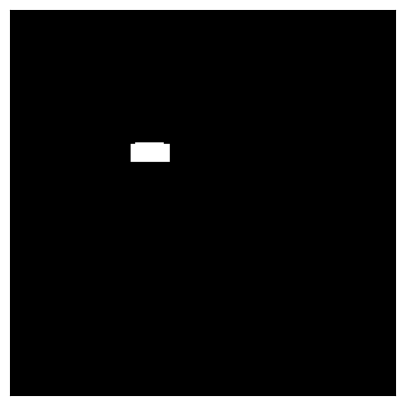

0.0


<Figure size 640x480 with 0 Axes>

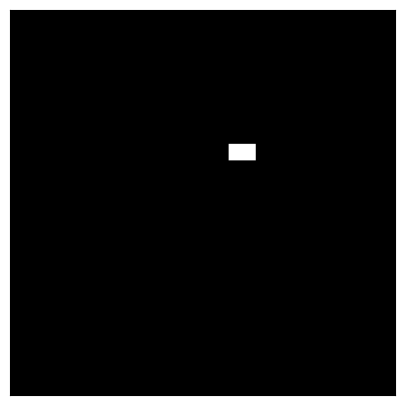

1.2566370614359172


<Figure size 640x480 with 0 Axes>

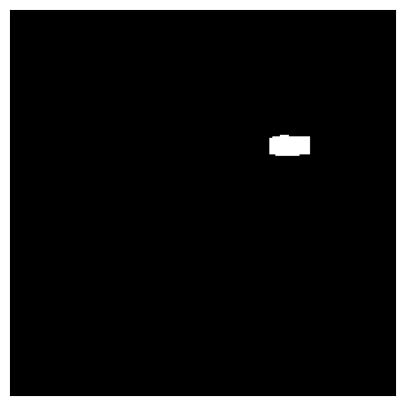

2.5132741228718345


<Figure size 640x480 with 0 Axes>

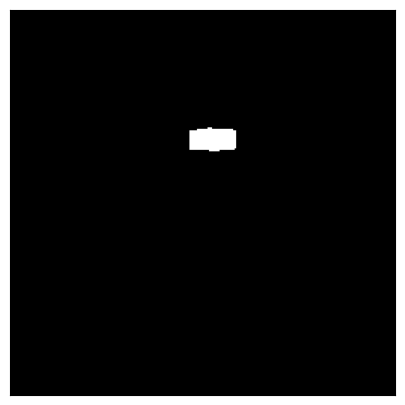

3.7699111843077517


<Figure size 640x480 with 0 Axes>

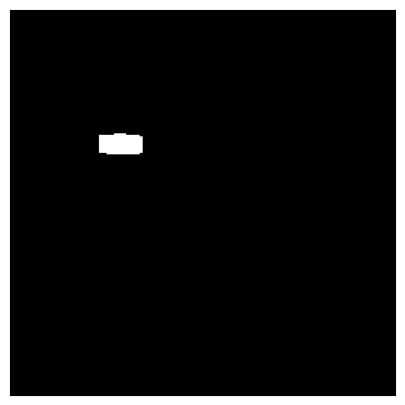

5.026548245743669


<Figure size 640x480 with 0 Axes>

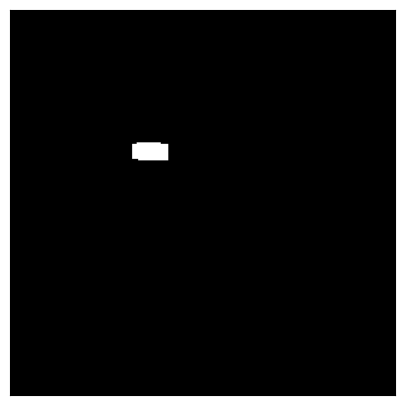

0.0


<Figure size 640x480 with 0 Axes>

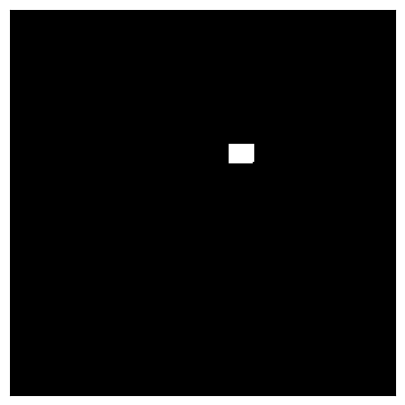

1.2566370614359172


<Figure size 640x480 with 0 Axes>

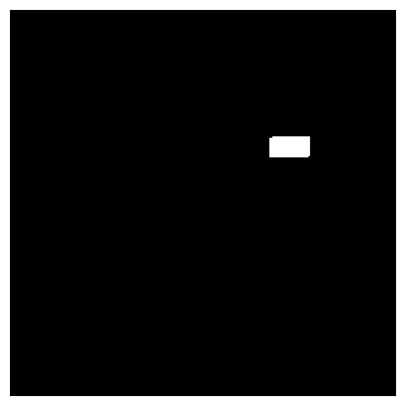

2.5132741228718345


<Figure size 640x480 with 0 Axes>

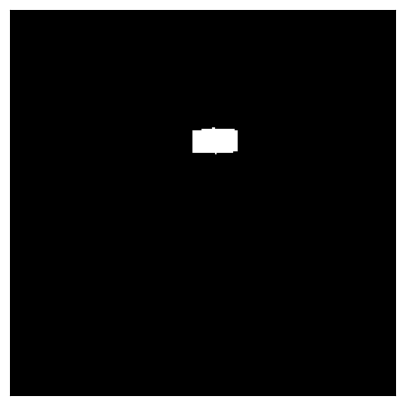

3.7699111843077517


<Figure size 640x480 with 0 Axes>

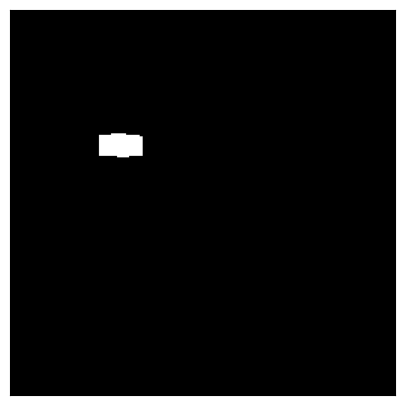

5.026548245743669


<Figure size 640x480 with 0 Axes>

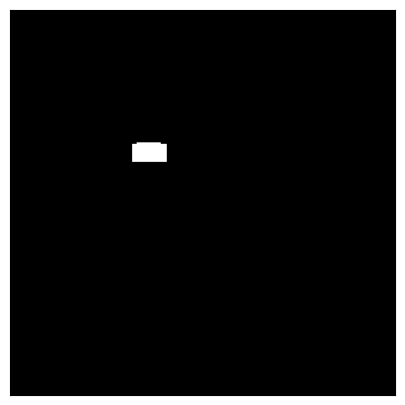

0.0


<Figure size 640x480 with 0 Axes>

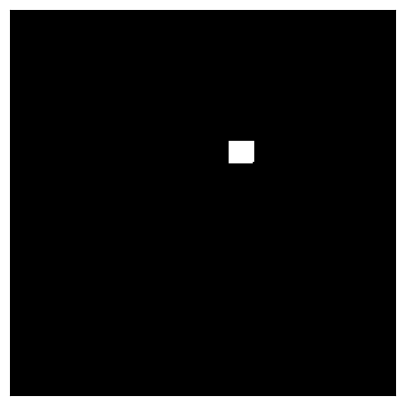

1.2566370614359172


<Figure size 640x480 with 0 Axes>

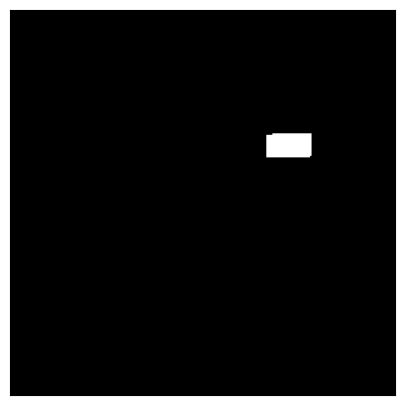

2.5132741228718345


<Figure size 640x480 with 0 Axes>

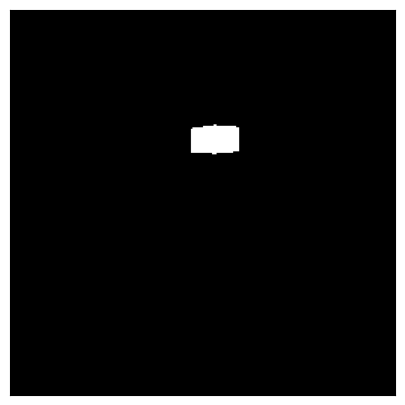

3.7699111843077517


<Figure size 640x480 with 0 Axes>

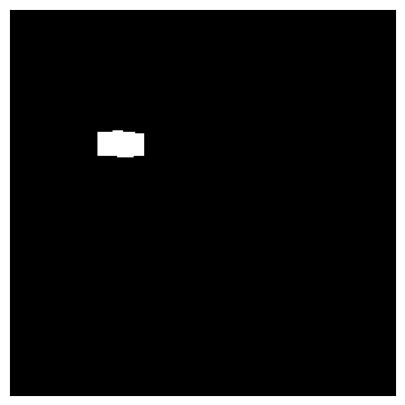

5.026548245743669


<Figure size 640x480 with 0 Axes>

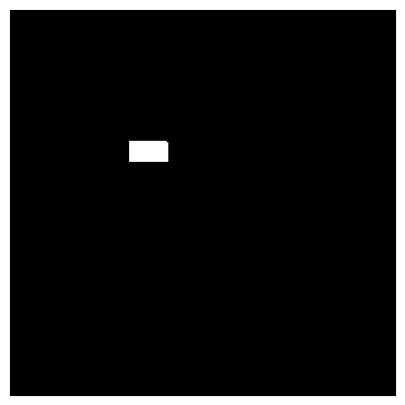

"    z= list(a.bbox())[2].start \n\n    plt.imshow(vol_ann[:, :, list(a.bbox())[2].start ].squeeze(), cmap='gray')\n    plt.show()   "

In [196]:
    
ann=scan.annotations ## annotation in scan
### Loop over annotations for CT volumes
for idx, a in enumerate(ann):
    ## create volume for the annotation
    vol_ann = np.zeros(vol.shape)
    vol_ann[a.bbox()] = 1  ### a.bbox() contains the gold standard (3D bounding box) of the localisation of each annotation 

    
    ## create drr object for the volume of the anotation
    ## create drr object from CT
    drr = DRR(
        vol_ann,      # The CT volume as a numpy array
        spacing,     # Voxel dimensions of the CT
        sdr=sdr,   # Source-to-detector radius (half of the source-to-detector distance)
        height=height,  # Height of the DRR (if width is not seperately provided, the generated image is square)
        delx=delx,    # Pixel spacing (in mm)
    ).to(device)
    
    ## generates the xray images 
    for idx_x in range(N_views):
        rad_x = idx_x*2*torch.pi/N_views
        print(rad_x)
        rotation = torch.tensor([[rad_x, rot_y , rot_z]], device=device) 

        # 📸 Also note that DiffDRR can take many representations of SO(3) 📸
        # For example, quaternions, rotation matrix, axis-angle, etc...
        img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
        img[img>0] = 1
        ### here use your favorite tool to save the created xray images s.
        ##visualisation
        plt.figure()
        plot_drr(img, ticks=False)
        plt.show()